# News Category Classification

This notebook covers the news category classification fector in order to detrermine fake news. 

## Dataset
To build model we will use BBC News data set.
* 2225  BBC news story documents from 2004-2005.
* Target Labels: 5 (business, politics, entertainment, tech, sport )
<br>
http://mlg.ucd.ie/datasets/bbc.html<br>
-D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

Formating to convert to csv.<br>
https://github.com/manojknit/MachineLearningModels/blob/master/DataEnrich/BBC_News_Category_Dataset.py


## 1. Data input
Loading csv file and doing encoding for

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  # stop words are, is, the etc. which are not needed for model
from nltk.stem.porter import PorterStemmer
!pip install gensim
from gensim.models import word2vec 
from sklearn.manifold import TSNE

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
    100% |████████████████████████████████| 23.6MB 545kB/s 
    100% |████████████████████████████████| 1.4MB 9.1MB/s 
    100% |████████████████████████████████| 133kB 25.4MB/s 
    100% |████████████████████████████████| 4.8MB 4.3MB/s 
    100% |████████████████████████████████| 61kB 21.8MB/s 
    100% |████████████████████████████████| 552kB 20.8MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [4]:
from google.colab import files
uploaded = files.upload()

Saving bbc-news-dataset.csv to bbc-news-dataset.csv


In [0]:
from StringIO import StringIO
df = pd.read_csv(StringIO(uploaded['bbc-news-dataset.csv']))
df['category_id'] = df['category'].factorize()[0]

In [29]:
catid, catlable = df['category'].factorize()
catlable

Index([u'business', u'sport', u'entertainment', u'tech', u'politics'], dtype='object')

In [0]:
#create dictionary
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

## Data Cleansing

In [0]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"^b", "", string)
    string = re.sub(r"\\n ", "", string)
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [68]:
# df['news'].head()

0    b'UK economy facing \'major risks\'\n \n The U...
1    b'Aids and climate top Davos agenda\n \n Clima...
2    b'Asian quake hits European shares\n \n Shares...
3    b'India power shares jump on debut\n \n Shares...
4    b"Lacroix label bought by US firm\n \n Luxury ...
Name: news, dtype: object

In [82]:
!pip install textblob
import nltk
nltk.download('wordnet')
from textblob import Word
df['news'] = df['news'].apply(lambda x : (' '.join([Word(word).lemmatize() for word in clean_str(x).split()])) )

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Exploratory Data Analysis (EDA)

Lets get some familiarity with the structure and features of the dataset.

A first step would be to look at some random news in each cataegory:

In [81]:
df.sample(5, random_state=0)

,id,news,category,category_id
384,384,b'World leaders gather to face uncertainty\n \...,business,0
1983,1983,b'UK \'discriminated against Roma\'\n \n The g...,politics,4
985,985,b'Ferguson rues failure to cut gap\n \n Boss S...,sport,1
1386,1386,b'US actor Ossie Davis found dead\n \n US acto...,entertainment,2
1294,1294,b'Stern dropped from radio stations\n \n Contr...,entertainment,2


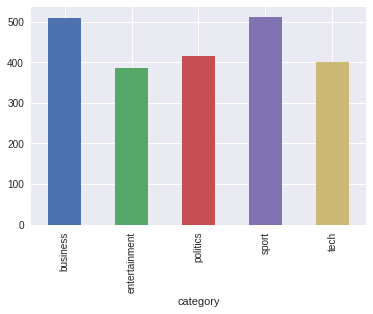

In [9]:
df.groupby('category').news.count().plot.bar(ylim=0)

We can see each category has almost same number of news. That is good for the model otherwise we need to manually adjust.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.news).toarray()
labels = df.category_id
features.shape

(2225, 14559)

Each of our 2225 documents is now represented by 14415 features, representing the tf-idf score for different unigrams and bigrams.

This representation is not only useful for solving our classification task, but also to familiarize ourselves with the dataset. For example, we can use the [chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) to find the terms are the most correlated with each of the categories:

In [11]:
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.iteritems()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . stock market
       . economic growth
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


Will use [**t-SNE**](https://lvdmaaten.github.io/tsne/) for dimensionality reduction and plot cluster.

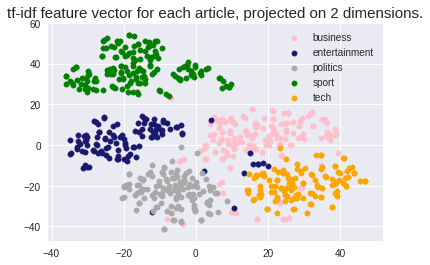

In [12]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.iteritems()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

Its good we can clearly distinguist different article categories.

Need to know outliers. Some points from a category falling in the middle of a different category. One of these outliers is a business article about the football club Arsenal, falling in the middle of a sport cluster:

In [13]:
df[df.news.str.contains('Arsenal')]

,id,news,category,category_id
89,89,b'Arsenal \'may seek full share listing\'\n \n...,business,0
568,568,b'Poll explains free-kick decision\n \n Refere...,sport,1
569,569,b'Bellamy fined after row\n \n Newcastle have ...,sport,1
572,572,b'Spain coach faces racism inquiry\n \n Spain\...,sport,1
573,573,b'Strachan turns down Pompey\n \n Former South...,sport,1
580,580,b'Parry firm over Gerrard\n \n Listen to the f...,sport,1
600,600,b'Henry tipped for Fifa award\n \n Fifa presid...,sport,1
610,610,b'Bridge could miss rest of season\n \n Chelse...,sport,1
632,632,b'Wenger offers Mutu hope\n \n Arsenal boss Ar...,sport,1
637,637,b'Campbell lifts lid on United feud\n \n Arsen...,sport,1


These outliers are little outliers so we can ignore.

## 3. Model Cross Validation

Lets compare models to apply.


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


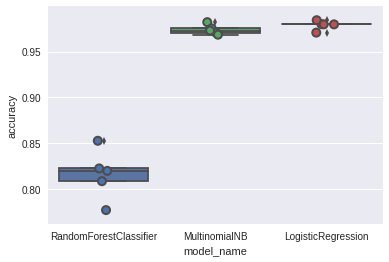

In [15]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.978872
MultinomialNB             0.973917
RandomForestClassifier    0.816111
Name: accuracy, dtype: float64

As per box plot `RandomForest` model shows a large variance, It reflects overfitting to its training data. Running cross-validation is necessary, because results from a single train/test split might be misleading.
On the other hand `MultinomialNB` (Naive Bayes) and `LogisticRegression` performed realy well. However `LogisticRegression` is having a slight edge with a median accuracy of around 97%.

## 4. Model Training and Validation

Lets train model and then analyze the main sources of misclassification on the test set. One way to eliminate sources of error is to look at the confusion matrix, a matrix used to show the discrepancies between predicted and actual labels.


### Train Test Split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

### Training

In [0]:
# Logistic Regression
model = LogisticRegression(random_state=0)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

### Validation

Text(0.5,15,u'Predicted')

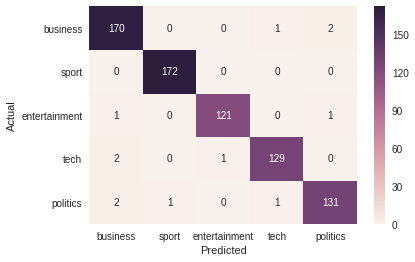

In [18]:
# Validation
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Given the extremely high accuracy of our model, the vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be! However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [19]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['news']])
      print('')

'tech' predicted as 'business' : 2 examples.


,news
1721,b'PC ownership to \'double by 2010\'\n \n The ...
1609,b'Man auctions ad space on forehead\n \n A 20-...



'politics' predicted as 'business' : 2 examples.


,news
2129,b'\'Super union\' merger plan touted\n \n Two ...
2198,b'\'Super union\' merger plan touted\n \n Two ...



'business' predicted as 'politics' : 2 examples.


,news
384,b'World leaders gather to face uncertainty\n \...
425,b'Saudi ministry to employ women\n \n Women wi...


As can be seen above, the misclassified articles are articles that touch on different subjects (for example, articles involving both politics and business) and might hence even be missclassified by humans. This sort of errors will always happen, and it is unrealistic to aim for a model that achieves 100% accuracy.

We can also look deeper inside the model and how it works, by finding which terms contribute the most to a document being classified in each of the categories:

In [20]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.iteritems()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . company
       . shares
       . bank
       . market
       . firm
  . Top bigrams:
       . chief executive
       . stock market
       . analysts said
       . economic growth
       . oil prices
# 'entertainment':
  . Top unigrams:
       . film
       . music
       . singer
       . tv
       . star
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . film festival
       . big brother
# 'politics':
  . Top unigrams:
       . labour
       . party
       . mr
       . government
       . election
  . Top bigrams:
       . mr blair
       . tony blair
       . prime minister
       . general election
       . mr brown
# 'sport':
  . Top unigrams:
       . match
       . cup
       . club
       . win
       . game
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . world number
       . bbc sport
# 'tech':
  . Top unigrams:
       . computer
       . users
       . 

This seems consistent with the terms we would expect, with the exception of the "tech" category, where the bigrams **`"bbc news"`** and **`"news website"`** are some of the most predictive. We also see that the **`"sport"`** category includes **`"bbc sport"`** as one of the most predictive bigrams.

This is confirmed by looking at the frequency of each category for articles containing **`"news website"`**:

In [22]:
df[df.news.str.lower().str.contains('news website')].category.value_counts()

tech             69
politics          8
entertainment     7
business          1
Name: category, dtype: int64

What is most likely happening is that the editorial style of the **"tech"** section is different, and often includes ther terms **`"bbc news"`**  and **`"news website"`**, in the same way the sports section includes **`"bbc sport"`**.

This is called a [**data leakage**](https://www.kaggle.com/wiki/Leakage), which is when information about the label we want to predict is accidentally added to the training set. In this specific case, our model still works equally good when excluding the leaky terms, but it's always good to be skeptical when a model performs unexpectedly well, hence the need for interpretable model instead of black-boxes that might work very well on the test set, but fail on real data.

For the record, we can also confirm that the model works well on data unrelated to the BBC, as can be seen in the examples below:

In [23]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'politics'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'



# Load Original fake news data to add feature

In [26]:
uploaded = files.upload()

Saving fake_real_dataset_spam.csv to fake_real_dataset_spam.csv


In [0]:
from StringIO import StringIO
df1 = pd.read_csv(StringIO(uploaded['fake_real_dataset_spam.csv']))

In [0]:
def combine_column(tuple1):
    if(pd.notna(tuple1[1])):
        if(tuple1[1].strip(' \t\n\r') == ''):
            return 'NA'
        else:
            return tuple1[1]
    elif(pd.notna(tuple1[0])):
        if(tuple1[0].strip(' \t\n\r') == ''):
            return 'NA'
        else:
            return tuple1[0]   
    else:
            return 'NA'

In [0]:
df1['content'] = df1[['title', 'text']].apply(combine_column, axis=1)

In [0]:
text_features1 = tfidf.transform(df1['content'])

In [0]:
#predictions
output1 = model.predict(text_features1)

In [0]:
df_output = pd.DataFrame(data=output1, columns=['category_fector'])

In [0]:
df1['category_fector'] = df_output.apply(lambda x:catlable[x])[['category_fector']]

In [60]:
df1.sample(5, random_state=0)

,Unnamed: 0,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,...,main_img_url,replies_count,participants_count,likes,comments,shares,type,content,spam_score_fector,category_fector
1095,1095,e2a9b33da3c30f2d576645416d4f91bbdb790962,0,BareNakedIslam,2016-11-06T23:08:05.041+02:00,"GERMANY: Bigger than the Berlin Wall, the 12-f...",BNI Store Nov 6 2016 GERMANY: Bigger than the ...,english,2016-11-06T23:08:05.041+02:00,barenakedislam.com,...,http://www.barenakedislam.com/wp-content/uploa...,0,1,0,0,0,bs,BNI Store Nov 6 2016 GERMANY: Bigger than the ...,0.997050,politics
248,248,5fccb20a0257e0d9fd1e1df51d43352f73288fdd,0,JinMI,2016-10-28T06:57:21.454+03:00,Oregon Standoff Leaders Acquitted For Malheur ...,Oregon Standoff Leaders Acquitted For Malheur ...,english,2016-10-28T06:57:21.454+03:00,abovetopsecret.com,...,http://files.abovetopsecret.com/images/ats15.jpg,0,1,0,0,0,bs,Oregon Standoff Leaders Acquitted For Malheur ...,0.973779,business
688,688,3144f77474072fe03b136d63e83a472b35dec307,0,Alex Ansary,2016-11-07T20:01:08.775+02:00,Hillary Clinton in lead a day before Election Day,Hillary Clinton in lead a day before Election ...,english,2016-11-07T20:01:08.775+02:00,amtvmedia.com,...,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,Hillary Clinton in lead a day before Election ...,0.970459,politics
2128,2128,e93ca1c6fc0ec4bbcc786b72e5449b75a16556fe,0,The Associated Press,2016-11-08T23:13:00.000+02:00,IN-StHou-56-elected - SFGate,NaN,english,2016-11-09T06:12:01.559+02:00,www.sfgate.com,...,http://www.sfgate.com/img/pages/article/opengr...,0,0,0,0,0,news,IN-StHou-56-elected - SFGate,0.866053,sport
1170,1170,6c9b8c99ce5cbb1543bff3265bbb5c1b5460cf26,0,beforeitsnews.com,2016-10-26T18:25:00.000+03:00,It is Time for Hillary Clinton to Duck and Go ...,(Before It's News)\r\n(image credit: Justin Su...,english,2016-10-26T22:06:55.438+03:00,beforeitsnews.com,...,http://s3-us-west-2.amazonaws.com/sleuthjourna...,0,1,1,0,1,bs,(Before It's News)\r\n(image credit: Justin Su...,0.929635,politics


In [0]:
df1.to_csv('fake_real_dataset_spam_category.csv')

In [0]:
#download back
files.download("fake_real_dataset_spam_category.csv")

In [30]:
#Clean Up container
#!rm 'fake_real_dataset_spam (2).csv'
#!rm *.*
#!ls

'business'

## Reference
https://github.com/manojknit/Natural_Language_Processing/blob/master/Topic%20Modeling%20t-SNE%20and%20Visualization.ipynb <br>
https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification<br>
https://www.kaggle.com/nlothian/fake-news-nlp-stuff